Found 120 files belonging to 3 classes.
Classes found: ['Bacterial leaf blight', 'Brown spot', 'Leaf smut']
Number of classes: 3
Bacterial leaf blight: 6 images
Brown spot: 23 images
Leaf smut: 24 images
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_12 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 sequential_13 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                               

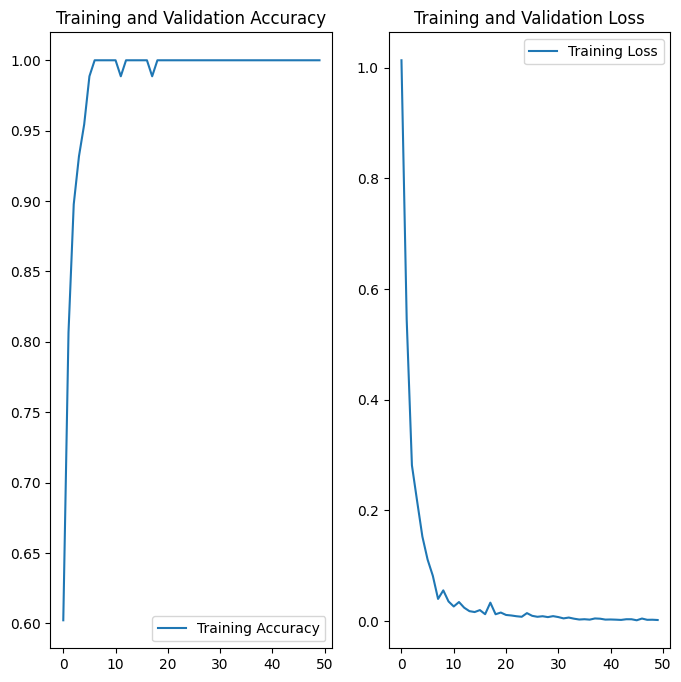

2/2 [==============================] - 2s 177ms/step


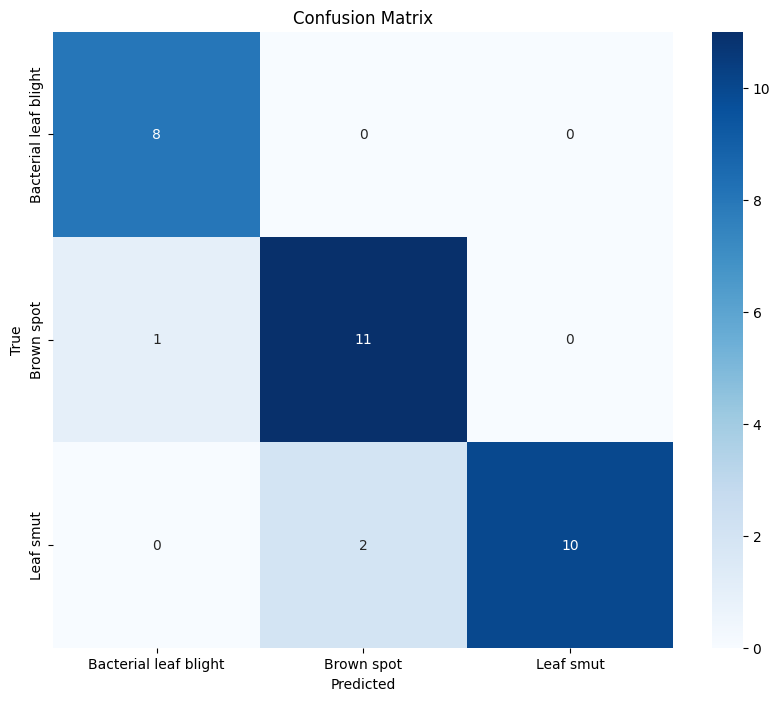

In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
import seaborn as sns
import json

# Constants
BATCH_SIZE = 16
EPOCHS = 50
IMG_HEIGHT = 224
IMG_WIDTH = 224
THRESHOLD = 0.5  # Confidence threshold for out-of-distribution detection

# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "rice_leaf_diseases",
    shuffle=True,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

# Get class names and determine the number of classes dynamically
class_names = dataset.class_names
n_classes = len(class_names)
print(f"Classes found: {class_names}")
print(f"Number of classes: {n_classes}")

# Analyze class distribution
for class_name in class_names:
    class_count = len([f for f in os.listdir(f"rice_leaf_diseases/{class_name}") if f.endswith(('jpg', 'jpeg', 'png'))])
    print(f"{class_name}: {class_count} images")

# Compute class weights for imbalanced datasets
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(n_classes),
    y=np.concatenate([y.numpy() for x, y in dataset])
)
class_weights = {i: weight for i, weight in enumerate(class_weights)}

# Function to partition the dataset into training, validation, and test sets
def get_dataset_partitions_tf(ds, train_split=0.8, test_split=0.1, val_split=0.1, shuffle_size=10000):
    ds_size = len(ds)
    ds = ds.shuffle(shuffle_size, seed=12)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, test_ds, val_ds

# Split the dataset
train_ds, test_ds, val_ds = get_dataset_partitions_tf(dataset)

# Optimize datasets for performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

# Preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMG_HEIGHT, IMG_WIDTH),
    layers.Rescaling(1.0 / 255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

# Use MobileNetV2 for transfer learning
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze the base model

# Build the model
model = models.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),  # Explicit input shape
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Display the model structure
model.summary()

# Add early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    class_weight=class_weights,  # Apply class weights for imbalance
    callbacks=[early_stopping]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# (Optional) Out-of-distribution detection function
def predict_with_threshold(model, image, threshold=THRESHOLD):
    predictions = model.predict(image)
    if max(predictions[0]) < threshold:
        return "Unknown"
    return class_names[np.argmax(predictions[0])]

# Plot training and validation results safely
acc = history.history.get('accuracy', [])
# Try to retrieve 'val_accuracy' first, otherwise 'val_acc'
val_acc = history.history.get('val_accuracy', history.history.get('val_acc'))
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss')

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
if val_acc is not None:
    plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
if val_loss is not None:
    plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Confusion matrix
y_true = np.concatenate([y.numpy() for x, y in test_ds])
y_pred = np.argmax(model.predict(test_ds), axis=-1)
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
import os
model_version = max([int(i) for i in os.listdir("../saved_models") if i.isdigit()] + [0]) + 1
save_path = f"../saved_models/{model_version}"
model.save(save_path, save_format="tf")

print(f"Model saved in TensorFlow SavedModel format at '{save_path}'")

INFO:tensorflow:Assets written to: ../saved_models/4\assets


INFO:tensorflow:Assets written to: ../saved_models/4\assets


Model saved in TensorFlow SavedModel format at '../saved_models/4'


In [7]:
model.save("../rice.h5")